# 통합 데이터 구축

* **가람님, 경대님, 정환님과 상의 후 프로 경기 메타데이터 중 50개의 데이터에 인게임 구간 입력**


* **기존 모듈을 활용하여 50개의 영상 데이터 다운로드**


* **OCR/OD 모델을 통과한 통합 데이터 확보**

In [1]:
# json 데이터 추출

import os
from analysis.remerge import Remerge

directory = os.getcwd() + '/data/rawdata'
file_list = os.listdir(directory)
file_list = [file for file in file_list if "Raw" in file]

for file in file_list:
    try:

        print('-----------------------------')
        file = file[:-18]
        
        if os.path.isfile(f'{os.getcwd()}/data/postprocessed/{file+".json"}'):
            print(f'{file} 존재')
            continue
            
        remerge = Remerge(file)
        remerge.to_json_data()
        print(f"{file} 까지 완료되었습니다.")
        
        
    except UnboundLocalError:
        print(f"{file} 에서 UnboundLocalError 에러")
        pass
    
    except KeyError:
        print(f"{file} 에서 KeyError 에러")
        pass
    
    except TypeError:
        print(f"{file} 에서 TypeError 에러")
        pass
    
    except ValueError:
        print(f"{file} 에서 ValueError 에러")
        pass

* **위 코드에서 보이듯이 Raw 데이터를 Json 형식으로 변환하는 과정에서 여러 이슈가 발생**


* **Raw 데이터를 체크 해본 결과 OCR 인식이 잘못 되어 에러가 발생한 것으로 추정**


* **여러 후처리를 적용해 해결한 경기도 있지만 해결되지 않은 에러도 여전히 존재하여 후처리 로직으로는 수정이 힘들다고 판단**


* **시간이 촉박한 관계로 오류가 발생한 경기들은 제외하여 총 30개의 게임으로 분석 진행**

# 분석 주제 선정

* **챔피언의 움직임이 담긴 좌표 데이터가 존재하였기 때문에, 동선에 초점을 맞춘 분석 희망**



* **가람님, 경대님, 정환님께 피드백을 받은 후 오브젝트 출현 시간대 각 팀별 라이너들의 행동 분석으로 주제를 수정하려 하였으나,**  
  **매 경기 마다 다른 출현시간을 가지고 있는 오브젝트는 분석에 어려움이 있을 것이라 판단**



* **따라서 원래 주제인 첫 전령 출현 시간대 라이너 행동 분석으로 주제 선정**



* **통합 데이터를 전령 시간대 데이터프레임으로 재구성**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from visualization import *
from data_preprocessing import *
from feature_engineering import *
from herald_route_clustering import *

path = os.getcwd()

df = pd.read_csv(path+'/data/Herald_time_csv/total_final.csv')

df

,gameid,gameclass,frame,time_stamp,time_stamp2,notice,replay,player.blue.T.name,player.blue.T.pick,player.blue.T.pick_key,...,player.red.S.name,player.red.S.pick,player.red.S.pick_key,player.red.S.KDA,player.red.S.CS,player.red.S.bounty,player.red.S.coordinate.x,player.red.S.coordinate.y,player.red.S.coordinate.w,player.red.S.coordinate.h
0,Raw_LPL_2021_Regional_Finals_009,0,324,06:00,360.0,5,False,LNGAle,Kennen,63,...,WEMissing,Thresh,130,0/0/0,8,NaN,261.787354,202.690994,25.507416,25.698425
1,Raw_LPL_2021_Regional_Finals_009,0,325,06:01,361.0,WEbeishang5,False,LNGAle,Kennen,63,...,WEMissing,Thresh,130,0/0/0,8,NaN,258.853577,200.345337,26.132294,25.862076
2,Raw_LPL_2021_Regional_Finals_009,0,326,06:02,362.0,NaN,False,LNGAle,Kennen,63,...,WEMissing,Thresh,130,0/0/0,9,NaN,257.434265,200.839249,26.261200,26.634979
3,Raw_LPL_2021_Regional_Finals_009,0,327,06:03,363.0,NaN,False,LNGAle,Kennen,63,...,WEMissing,Thresh,130,0/0/0,9,NaN,256.280487,201.238586,25.134445,25.853165
4,Raw_LPL_2021_Regional_Finals_009,0,328,06:04,364.0,WCBreatheWEbeishang5,False,LNGAle,Kennen,63,...,WEMissing,Thresh,130,0/0/0,9,NaN,253.819305,206.543930,24.788681,25.077728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5246,Raw_PCS_2020_Summer_092,29,499,08:56,536.0,ahqZiv,False,PSG Hanabi,Renekton,103,...,ahq Ysera,Tahm Kench,125,0/0/0,10,NaN,289.790405,20.645927,24.674805,24.707779
5247,Raw_PCS_2020_Summer_092,29,500,08:57,537.0,NaN,False,PSGHanabi,Renekton,103,...,ahq Ysera,Tahm Kench,125,0/0/0,10,NaN,285.589294,26.056656,25.301422,24.862404
5248,Raw_PCS_2020_Summer_092,29,501,08:58,538.0,NaN,False,PSG Hanabi,Renekton,103,...,ahq Ysera,Tahm Kench,125,0/0/0,10,NaN,282.228882,32.129898,25.282867,25.534468
5249,Raw_PCS_2020_Summer_092,29,502,08:59,539.0,NaN,False,PSG Hanabi,Renekton,103,...,ahq Ysera,Tahm Kench,125,0/0/0,10,NaN,278.738953,37.695332,24.788422,24.618708


# 분석 과정

## Data preprocessing

### 1. 좌표 스케일 조정

* **OCR/OD 모델에서 정확히 미니맵만 크롭된 이미지 외에 미니맵 주변도 포함된 croped_minimap.png 가 존재함**



* **또한 croped_minimap.png 마다 사이즈가 다르기 때문에,
    각 팀의 우물 좌표를 기준으로 잡고, 좌표들의 스케일을 조정**


* **좌표가 인식이 안되는 경우가 잦더라도, 한 번은 귀환한 좌표가 인식이 될거라 판단, 최소값과 최대값을 우물 좌표의 기준으로 설정**

```
blue_home_x = df[blue_x_loc_list].min().min()
blue_home_y = df[blue_y_loc_list].max().max()    
red_home_x = df[red_x_loc_list].max().max()
red_home_y = df[red_y_loc_list].min().min()
```

In [3]:
dfs = []
for i in df['gameclass'].unique():
    game = df[df['gameclass']==i].reset_index(drop=True)
    game = scailing(game)
    dfs.append(game)

df = pd.concat(dfs, axis=0, ignore_index=True)

### 2. 동선 결측치 보완

* **좌표가 존재하지 않아 동선 카테고리화(다음 챕터에서 설명)를 실패한 경우, 값이 있는 가장 가까운 프레임의 동선으로 대체**

In [4]:
df = loc_category(df)
df = fill_zero_route(df)

**위 과정을 모듈화 (data_preprocessing.py)**

## Featrue engineering

### 1. 기존 feature : 챔피언별 (x, y)좌표



⭢ 새로운 feature 생성



* 우물로부터의 거리를 활용한 맵 장악력  

    ex) 우물로부터의 거리가 가장 먼 세 챔피언의 거리 평균의 MinMaxscale

    시야 점수 지표를 확보하기 어려워, 대체 지표로 사용  

    
* 바운딩 박스를 활용한 동선 카테고리화(Label encoding)  

    ex) 블루늑대=1 / 블루탑=2 / 블루우물=3 등  

    행동 분석에 관련없는 무빙을 제외한 동선을 파악하기 유리  


In [5]:
dfs = []
for i in df['gameclass'].unique():
    game = df[df['gameclass']==i].reset_index(drop=True)
    game = make_distance(game)
    dfs.append(game)

df = pd.concat(dfs, axis=0, ignore_index=True)

In [6]:
# df = loc_category(df)

### 2. 기존 feature : 챔피언별 KDA



⭢ 새로운 feature 생성



* kill_score  

    ex) blue : 14 / red : 12

    다른 지표와 함께 팀의 유불리 판단 지표로 사용


* kda_score  

    ex) KDA : 3/4/1 -> kda.score : 1 

    다른 지표와 함께 라인별 유불리 판단 지표로 사용

In [7]:
dfs = []
for i in df['gameclass'].unique():
    game = df[df['gameclass']==i].reset_index(drop=True)
    game = make_kill_score(game)
    game = make_kda_score(game)
    dfs.append(game)
    
df = pd.concat(dfs, axis=0, ignore_index=True)

### 3. 기존 feature : 챔피언별 CS



⭢ 새로운 feature 생성



* 팀 Total CS  

    ex) blue : 256 / red : 188

    다른 지표와 함께 팀의 유불리 판단 지표로 사용


* 이전 프레임 대비 개인 별 CS 변화  

    ex) 00분 13초 : 0 / 00분 14초 : 0 -> 00분 15초 : 1

    그냥 라인에 모습만 보인 건지, 라인을 밀고 있는지 등 행동 지표로 사용 

In [8]:
dfs = []
for i in df['gameclass'].unique():
    game = df[df['gameclass']==i].reset_index(drop=True)
    game = make_total_cs(game)
    game = make_cs_change(game)
    dfs.append(game)
    
df = pd.concat(dfs, axis=0, ignore_index=True)

**위 과정을 모듈화 (feature_engineering.py)**

## Visualization

### 1. 라이너 별 움직임의 불연속성과 결측값을 확인하기 위한 시각화

* **데이터 전처리를 하는 과정에서 좌표 결측치를 잘 못 보완 했을 경우, 시각화를 통해 잘 못 보완된 결측치를 확인 할 수 있을 것이라 판단**


* **하지만 모든 경기를 시각화 할 수 없으리라 판단하였고, 좌표 결측치를 보완한다는 자체가 데이터를 손상 시키는 행위라 판단하여 추후에 좌표 값 대신 카테고리로 클러스터링을 실시했기 때문에 최종적으로 사용하지는 않음**

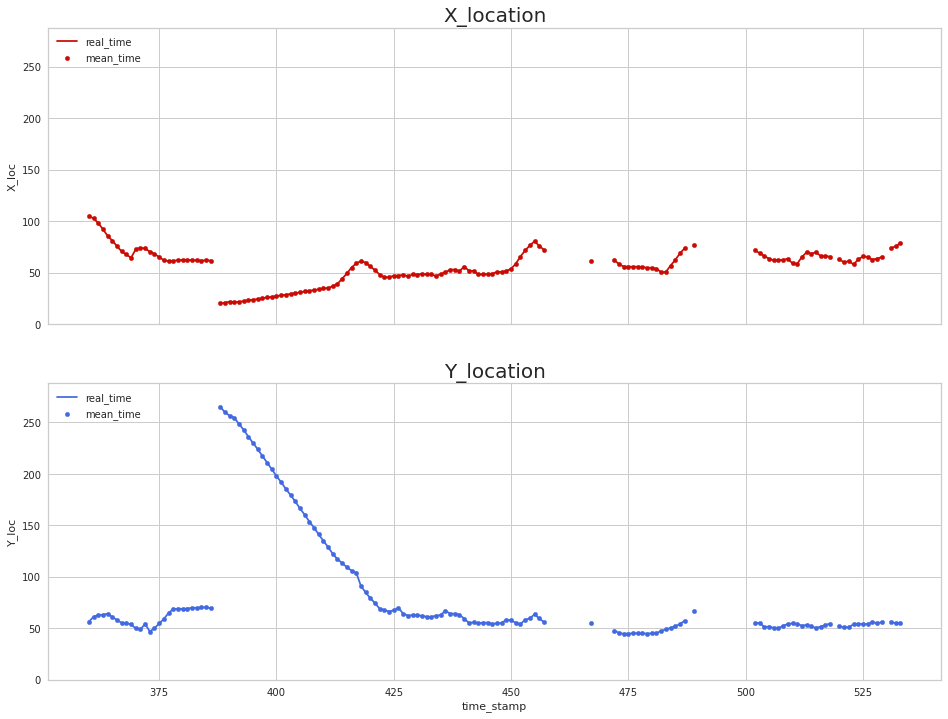

In [11]:
loc_graph(df[df['gameclass']==3], position="T", team="blue")

### 2. 미니맵으로 동선 시각화


* **영상을 하나하나 확인하기에는 비효율적이라고 판단하여, 시간의 흐름에 따른 챔피언의 이동을 시각화 하기로 결정**

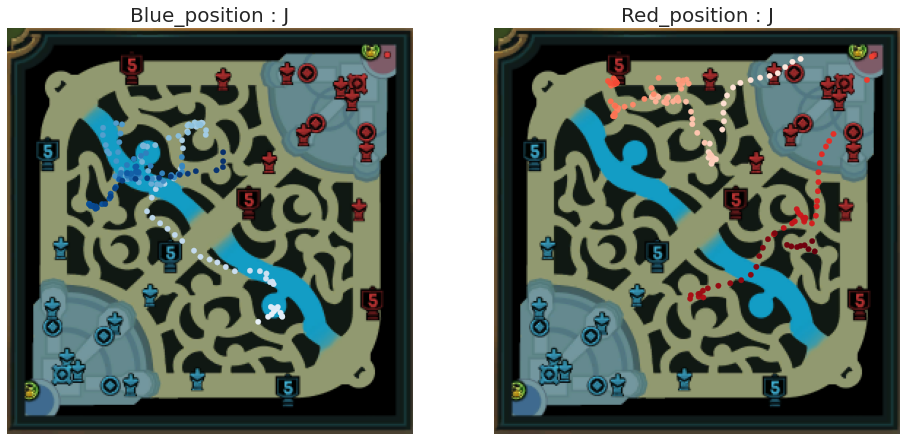

In [13]:
loc_minimap(df[df['gameclass']==1], position='J')

### 3. 추후에 사용할 시각화 함수

- elbow visualization
- silhouette_visualization
- piechart


## Clustering

* **팀별 / 라이너별 첫 전령 출현 시간대의 동선을 군집화 하여 각 그룹 간 지표간의 유의미한 차이들에 대해 분석하기로 판단**


* **시간의 흐름에 따른 움직임이 중요하다고 판단했기 때문에, tslearn 라이브러리의 시계열 데이터 군집화(TimeSeriesKmeans)를 사용하여 군집화**


* **TimesSeriesKMeans에서 metric을 "Euclidean"이 아닌 "dtw"를 이용했는데, 그 이유는 리플레이 구간의 좌표값이 없는 경우가 있기 때문에 오류를 예방하기 위해서 시간의 역동적인 흐름을 반영하는 dtw를 선택**


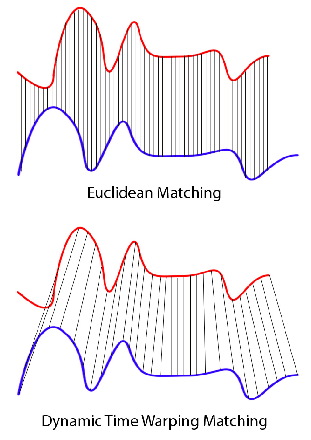


* **처음에는 x좌표와 y좌표 각각의 흐름을 군집화 한다면 오류가 분명히 있을거라 판단, 따라서 주성분분석(PCA) 차원축소를 통해 하나의 축으로 좌표를 축소한 다음, 시계열 데이터 군집화를 진행하였지만 Silhouette_score가 매우 낮음을 확인**


* **Silhouette_score가 낮은 이유에는 여러가지가 있겠지만 연속적인 좌표값을 통해 군집화를 하는 것은 무리가 있을 것이라고 판단, 따라서 동선 카테고리 값을 군집 지표로 사용하기로 결정**

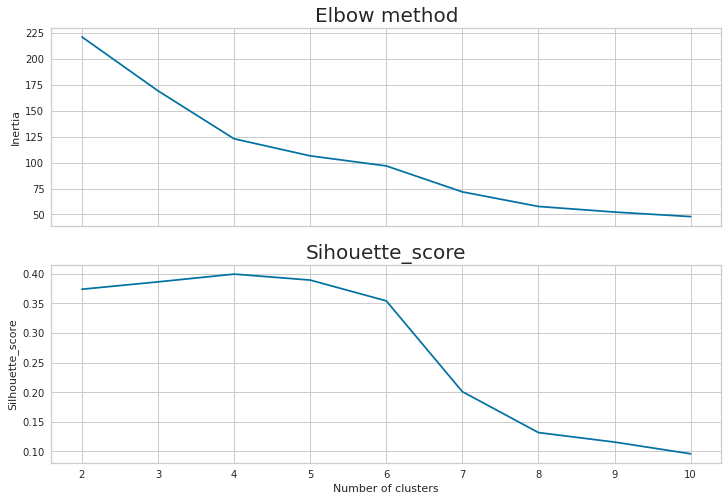

In [25]:
evaluating_ts_cluster(df, position="M", team="blue")

* **파라미터 튜닝 과정에서 군집화 평가 척도 들을 고려해 본 결과, 군집의 개수는 4가 적절하다고 판단**


* **데이터프레임에 군집화 적용**

In [15]:
df = merge_category_ts_cluster(df, n=4)

cluster_list = [cluster for cluster in df.columns.tolist() if "cluster" in cluster]

df[cluster_list]

,player.blue.T.cluster,player.blue.J.cluster,player.blue.M.cluster,player.blue.A.cluster,player.blue.S.cluster,player.red.T.cluster,player.red.J.cluster,player.red.M.cluster,player.red.A.cluster,player.red.S.cluster
0,1,0,0,0,2,3,1,2,0,3
1,1,0,0,0,2,3,1,2,0,3
2,1,0,0,0,2,3,1,2,0,3
3,1,0,0,0,2,3,1,2,0,3
4,1,0,0,0,2,3,1,2,0,3
...,...,...,...,...,...,...,...,...,...,...
5246,1,0,2,3,3,2,1,2,0,2
5247,1,0,2,3,3,2,1,2,0,2
5248,1,0,2,3,3,2,1,2,0,2
5249,1,0,2,3,3,2,1,2,0,2


* **각 군집의 비율을 파이차트로 시각화**

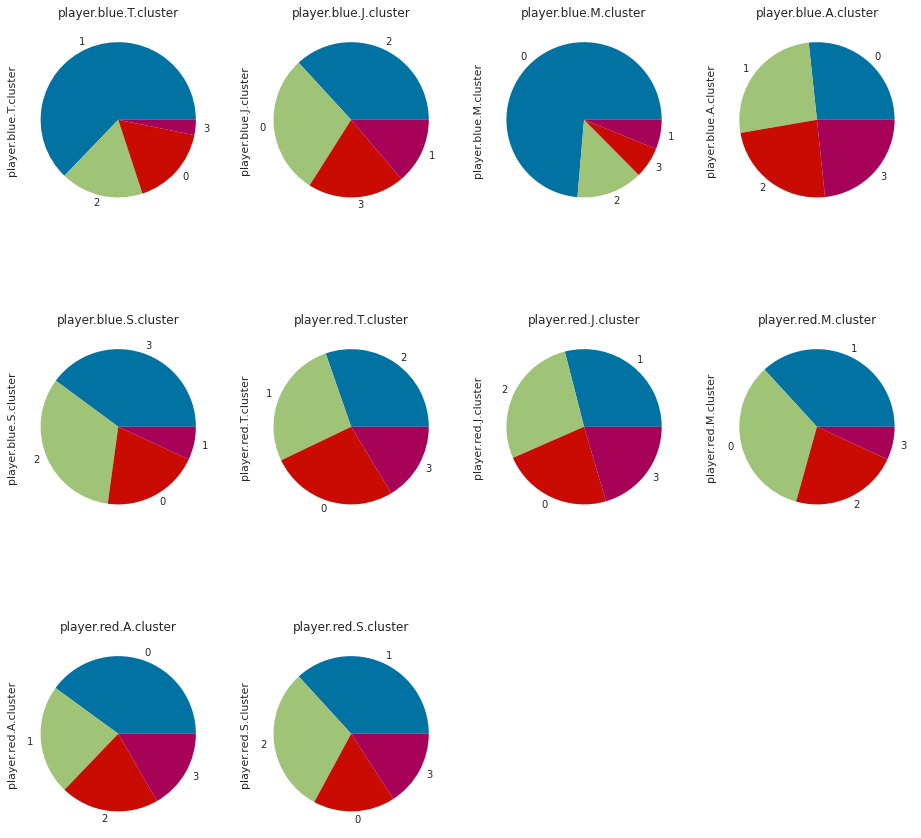

In [17]:
piechart(df)

* **예시로, Blue 팀 Mid 라이너의 동선 시각화**

In [18]:
df['player.blue.M.cluster'].value_counts()

0    3867
2     724
3     339
1     321
Name: player.blue.M.cluster, dtype: int64

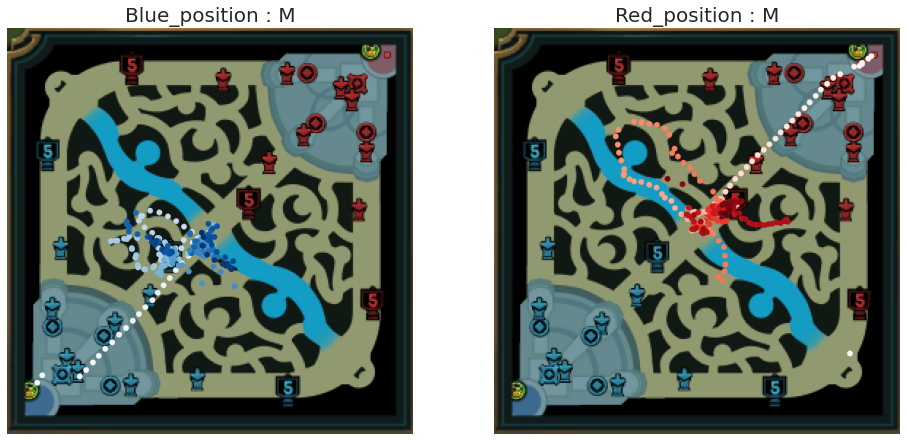

In [19]:
loc_minimap(df[df['player.blue.M.cluster']==1], position='M')

* **1번 그룹은 전령이 출현하더라도 아무런 개입없이 라인전을 계속 진행하는것으로 보임**

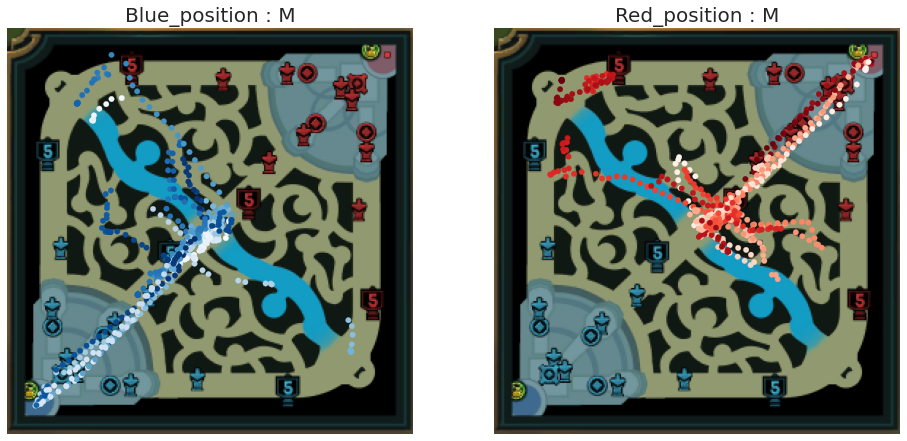

In [20]:
loc_minimap(df[df['player.blue.M.cluster']==2], position='M')

* **2번 그룹은 전령이 출현하자마자 또는 그 바로 전후에 직접적으로 전령 쟁취에 개입하는 것으로 보임**

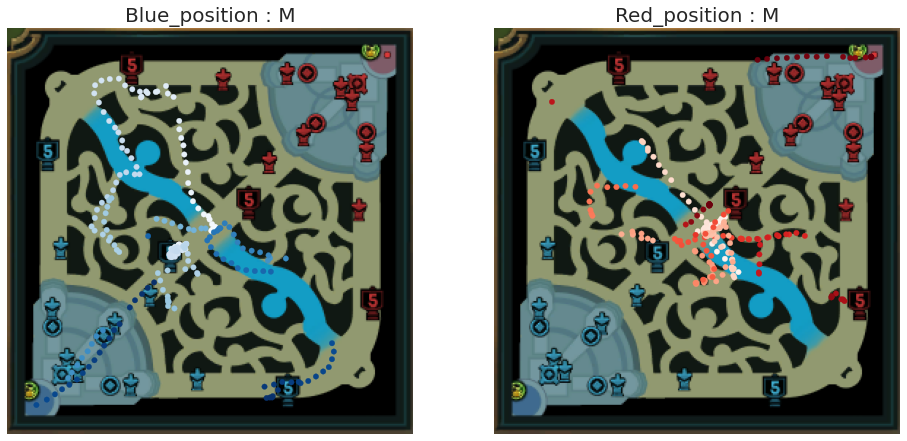

In [21]:
loc_minimap(df[df['player.blue.M.cluster']==3], position='M')

* **3번 그룹은 2번 그룹과 비슷해 보이나,**

    **전령이 출현하기 한참 전에 탑라인에 로밍을 가서 전령 주도권을 미리 획득한다는 점에서
    2번 그룹과의 차이를 알 수 있음**

**+ 군집별 동선이 어떠한 특성을 가지고 있는지, 그룹간 유의미한 차이가 있는지 등 생성한 지표들을 통해 통계 검정이나**


**시각화를 해보고 싶었는데, 시간을 효율적으로 쓰지 못하여 아쉬움이 많이 남은 결과이다.**

# 회고

## 임도현

사실 제대로된 데이터 전처리를 해보지도 못하고, 기껏 만들어놓은 지표들도 사용하지 못해서 많이 아쉽습니다.

동선을 군집화하는 것으로 끝내는 것이 원래 목표는 아니였고, 군집들의 특성들을 각종 지표들을 통해 분석하는 것이 목표였습니다.

개인적으로는 군집별 다른 지표들의 차이에 대한 통계 검정도 해보고 싶었고,

시각화를 통한 차이들도 확인해보고 싶었는데 생각보다 그 전 작업에서 시간이 오래 걸렸습니다. 

또한 저희 힘으로 핸들링 하지 못하여 분석에 사용하지 않은 데이터들도 아까운 마음이 한편으로는 듭니다.

많은 분들이 아이디어도 주시고 해결하는데 같이 힘써주셔서 감사하고, 특히 혜린님 저랑 같이 머리 맞대고 고민하시느라 감사했습니다!  

짧은 기간이였지만 제 나름대로 열심히 한 것 같고 좋은 조언도 많이 해주시고  

술도 많이 먹어서(?) 정말 즐겁고 유익한 생활이었습니다~~~~  


## 김혜린
정말 좋은 기회를 얻어 여기에서 한달동안 일했다는 사실이 꿈만 같습니다ㅜㅜ

솔직히 데이터 분석을 해볼 기회가 많이 없었는데, 여기와서 다른 분들이 하시는 분석도 보고,

주신 데이터로 도현님과 제가 직접 뭔갈 적용해보고 하는게 너무 도움이 많이 되었습니다!

위에서 도현님이 말씀하신거처럼 지표도 더 많이 사용해보고 다른 분석도 해보고 싶지만 한달이 참 짧네요 ㅠㅠㅎㅎ

많이 부족한 저랑 같이 열심히 해주신 도현님 너무 감사하구, 가람님 경대님 정환님도 계속 조언해주시구 도와주셔서 너무 감사합니다!!!

다른 데이터셀 분들도 잘챙겨주셔서 너무 감사하구 여기가 인연의 끝이 아니였으면 좋겠습니당!!

여기서 일하지 않고는 알 수 없는 지식들에 대해 많이 배워가서 대학원가선 더 열심히 해보도록 하겠습니다 ㅎㅎㅎ

모두 정말 너무 감사합니다!!!! 꼭 똑똑해져서 돌아오겠습니다 ㅋㅋㅋㅋ 부산오시면 언제든 다들 연락주세요 ><